#### Импорт датасета и пакетов. 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier, MLPRegressor


In [3]:
df = pd.read_csv('dataset.csv')


## 📊EDA и ресерч-анализ. Графики, применение инструментов EDA. Комментарий до графика. Вывод после графика/стат методов. Корреляция колонок с таргетом.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [6]:
df.isna().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
correlation_matrix = df.corr(numeric_only=True)
target_correlation = correlation_matrix['popularity'].sort_values(ascending=False)

print("Корреляция признаков с популярностью:\n")
print(target_correlation[1:])

Корреляция признаков с популярностью:

loudness            0.050420
explicit            0.044078
danceability        0.035444
Unnamed: 0          0.032146
time_signature      0.031076
tempo               0.013212
energy              0.001053
key                -0.003847
liveness           -0.005397
duration_ms        -0.007129
mode               -0.013948
acousticness       -0.025458
valence            -0.040522
speechiness        -0.044930
instrumentalness   -0.095147
Name: popularity, dtype: float64


Датасет состоит из 21 колонки, большинство из которых составляют типы int и float. 
Количество NaN незначительно, их можно просто удалить. 

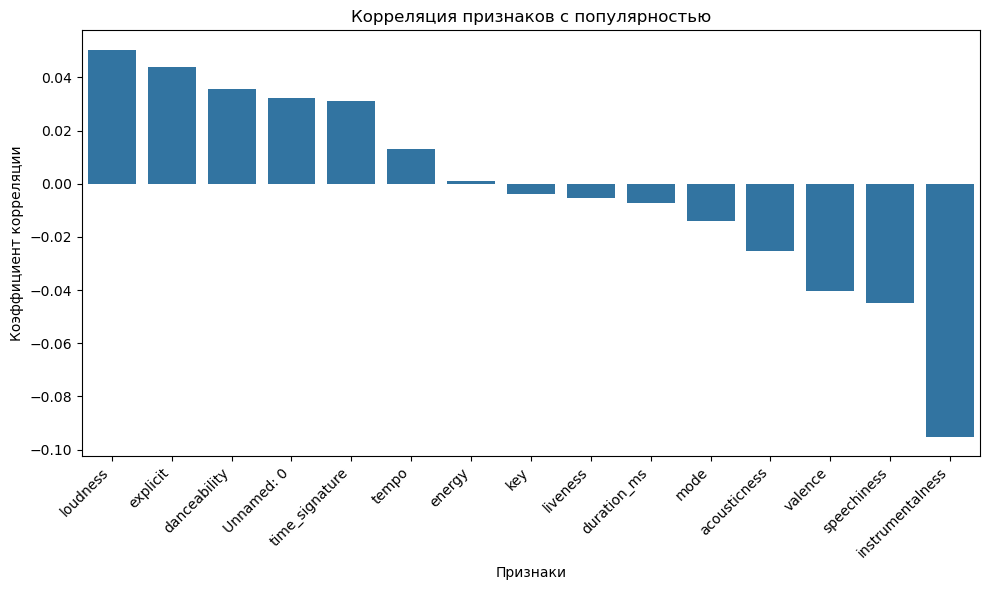

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x=target_correlation[1:].index, y=target_correlation[1:].values)
plt.xticks(rotation=45, ha='right')
plt.title("Корреляция признаков с популярностью")
plt.ylabel("Коэффициент корреляции")
plt.xlabel("Признаки")
plt.tight_layout()
plt.show()

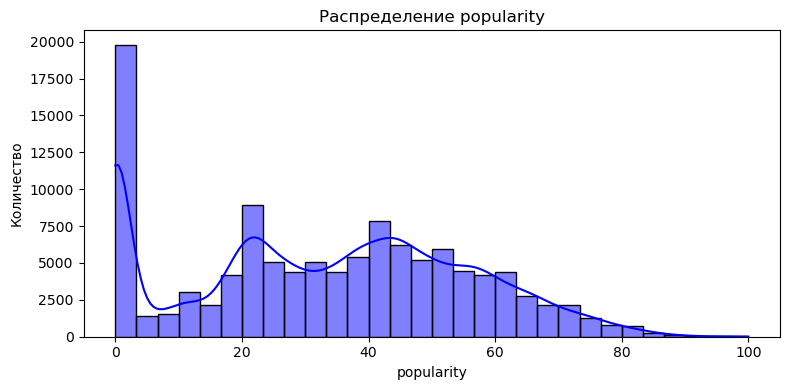

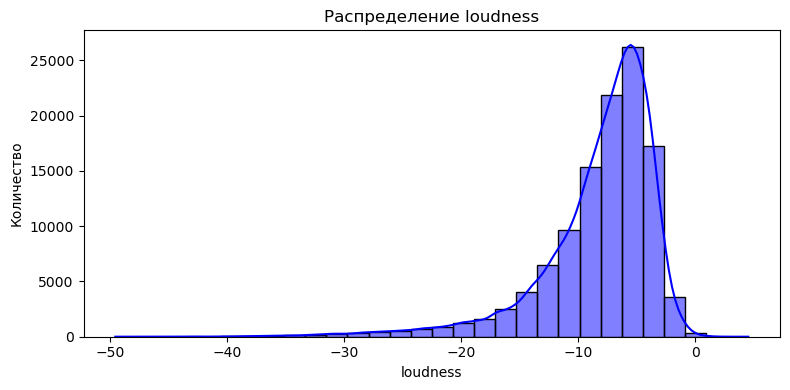

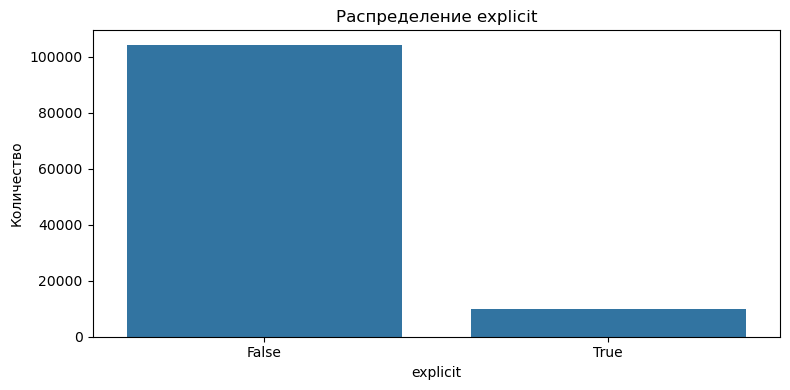

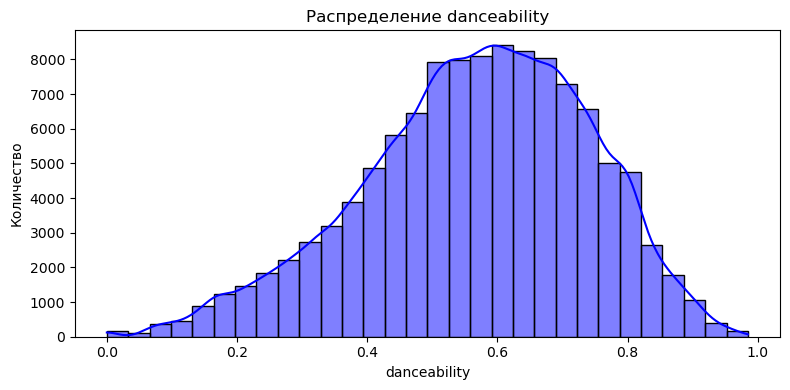

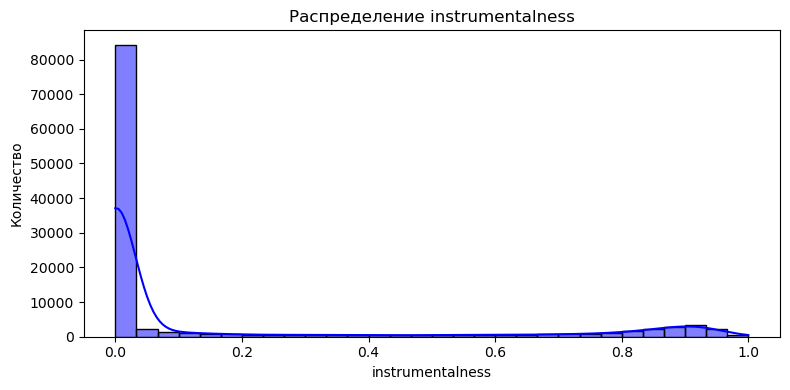

In [11]:
key_features = ['popularity', 'loudness', 'explicit', 'danceability', 'instrumentalness']
for feature in key_features:
    plt.figure(figsize=(8, 4))
    if df[feature].dtype == 'bool' or len(df[feature].unique()) < 10:
        sns.countplot(data=df, x=feature)
    else:
        sns.histplot(data=df, x=feature, kde=True, bins=30, color='blue')
    plt.title(f"Распределение {feature}")
    plt.xlabel(feature)
    plt.ylabel("Количество")
    plt.tight_layout()
    plt.show()

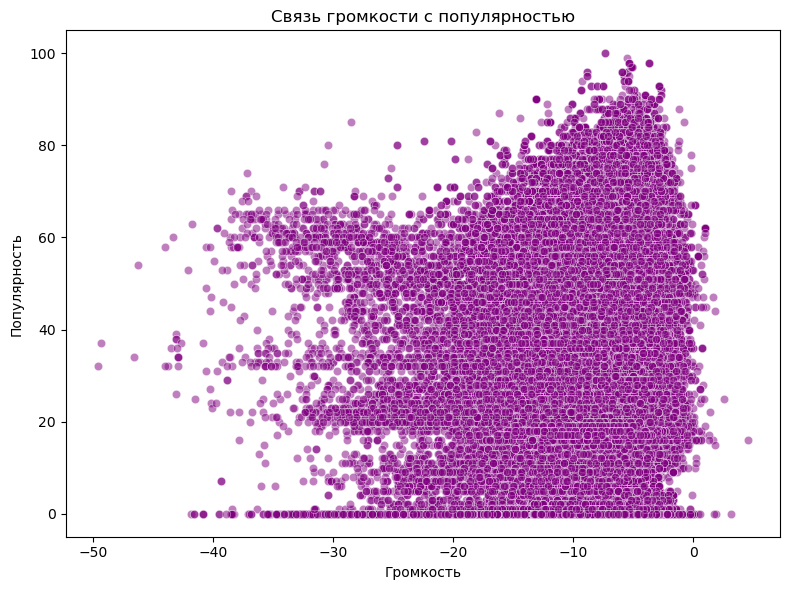

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='loudness', y='popularity', alpha=0.5, color='purple')
plt.title("Связь громкости с популярностью")
plt.xlabel("Громкость")
plt.ylabel("Популярность")
plt.tight_layout()
plt.show()

## Краткие выводы по первой части работы:

### Корреляция признаков с популярностью:

- Анализ корреляционной матрицы показал, что корреляция между популярностью (popularity) и другими числовыми признаками в целом низкая.
- Признаки с наибольшей положительной корреляцией:
    - loudness (громкость): умеренная положительная корреляция, что говорит о возможной тенденции, что более громкие треки чаще популярны.
    - explicit (наличие пометки о нецензурности): также имеет слабую положительную корреляцию.
    - danceability (танцевальность): слабая положительная корреляция.
- Признаки с отрицательной корреляцией:
    - instrumentalness (инструментальность): треки с высокой инструментальностью чаще менее популярны.
    - speechiness (наличие речевых элементов): слабая отрицательная корреляция.
    - valence (позитивность): также показывает слабую отрицательную связь.

### Распределение ключевых признаков:

- Popularity: распределение популярности треков имеет смещение, большинство треков имеют средний уровень популярности, с меньшим числом крайне популярных или непопулярных треков. Большое количество треков имеют нулевую популярность. Вероятно, их следует удалить для улучшения показателей метрик модели. 
- Loudness: близко к нормальному распределению, большинство треков имеют громкость в диапазоне от -10 до -5 дБ.
- Explicit: большая часть треков не содержит меток "explicit".
- Danceability: распределение смещено в область от 0.5 до 0.8, что говорит о предпочтении треков со средней танцевальностью.
- Instrumentalness: большая часть треков практически не инструментальны, значение близкое к нулю.

### Связь громкости с популярностью:

На графике видно, что с увеличением громкости популярность слегка возрастает, но зависимость не линейная и имеет большое количество выбросов.

### Итог:

Несмотря на слабую корреляцию большинства признаков с популярностью, такие характеристики, как громкость, танцевальность и нецензурность, могут иметь практическое значение при решении задачи регрессии. 

Также некоторые признаки, такие как instrumentalness, скорее негативно влияют на популярность, что может быть полезно для решения задачи. 

Однако, как сказано выше, сильной корреляции какого-либо признака с популярностью нет, что подталкивает нас к комплексному решению по нескольким признакам. 

## 👨‍💻Feature Engineering. Корреляция новых колонок с таргетом. Feature Importances. Простая модель.

In [15]:
df.drop(columns=['track_id','Unnamed: 0'], inplace=True)
# удаление идентификаторов

In [16]:
df = df[df['popularity'] != 0]

In [17]:
corr_matrix = df.corr(numeric_only=True)

high_corr = corr_matrix[(corr_matrix > 0.5) & (corr_matrix != 1.0)]

high_corr = high_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)

print("Корреляции выше 0.5")
print(high_corr)

Корреляции выше 0.5
            energy  loudness
energy         NaN  0.758836
loudness  0.758836       NaN


In [18]:
df['energy_loudness'] = df['energy'] * df['loudness']
df.drop(columns=['energy','loudness'], inplace=True)

In [19]:
skewness = df.skew(numeric_only=True)
high_skew = skewness[skewness > 1]
positive_columns = df[high_skew.index].min() > 0
log_candidates = high_skew[positive_columns]

print("Колонки с высоким skewness, подходящие для логарифмирования:")
print(log_candidates)

Колонки с высоким skewness, подходящие для логарифмирования:
duration_ms    11.559447
dtype: float64


In [20]:
df['log_duration_ms'] = np.log1p(df['duration_ms'])
df.drop(columns=['duration_ms'], inplace=True)

In [21]:
df['multiple_artists'] = df['artists'].str.contains(';')
df.drop(columns=['artists'], inplace=True)

In [22]:
X = df.drop(columns=['popularity', 'album_name', 'track_name','track_genre'])
y = df['popularity']

X_sample = X.sample(frac=0.3, random_state=42)  
y_sample = y.loc[X_sample.index]

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)
perm_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean}).sort_values(by='Importance', ascending=False)

print(perm_df)


             Feature  Importance
6   instrumentalness    0.154020
8            valence    0.118909
5       acousticness    0.101390
4        speechiness    0.084001
12   log_duration_ms    0.082257
1       danceability    0.073168
11   energy_loudness    0.046981
9              tempo    0.035061
7           liveness    0.033755
13  multiple_artists    0.020296
0           explicit    0.010516
2                key    0.008485
3               mode    0.004712
10    time_signature    0.001968


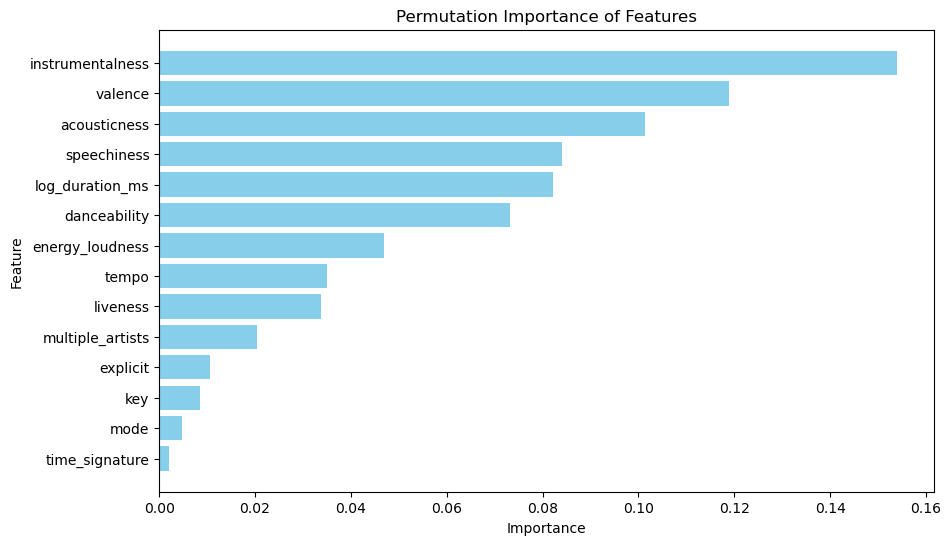

In [23]:
plt.figure(figsize=(10, 6))
plt.barh(perm_df['Feature'], perm_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance of Features')
plt.gca().invert_yaxis()  # Инвертируем ось для отображения от более важного к менее важному
plt.show()

### Определены следующие важные признаки в ходе выявления Feature importance:

#### instrumentalness (0.154):

    Этот признак указывает на уровень инструментальности трека. Чем выше значение, тем меньше в треке вокальных элементов.
    Высокая значимость этого признака может быть связана с тем, что инструментальные треки привлекают определённую аудиторию, например, для фоновой музыки или плейлистов для работы и релаксации.

#### valence (0.119):

    Характеризует настроение или позитивность трека. Значение от 0 (грустный/негативный трек) до 1 (радостный/позитивный трек).
    Важность этого признака может быть объяснена тем, что настроение трека напрямую влияет на его популярность в зависимости от потребностей аудитории (например, музыка для вечеринок, расслабления или мотивации).

#### acousticness (0.101):

    Определяет степень "акустичности" трека. Высокое значение указывает на то, что трек больше напоминает живое исполнение.
    Популярность акустических треков может быть связана с трендом на более натуральное звучание или живые концерты.

#### speechiness (0.084):

    Указывает на количество слов в треке. Высокое значение связано с речевыми композициями, например, подкастами или рэпом.
    Значимость этого признака объясняется тем, что аудитория может предпочитать треки с ярко выраженным вокалом или рэп-элементы.

#### log_duration_ms (0.082):

    Логарифм длительности трека в миллисекундах. Этот показатель важен, так как слишком короткие или длинные треки могут быть менее популярными.
    Треки оптимальной длительности (например, 2–4 минуты) могут лучше удерживать внимание слушателей, что влияет на популярность.

In [25]:
# One-Hot Encoding 
print(f"Изначальное количество колонок: {df.shape[1]}")
df = pd.get_dummies(df, columns=['track_genre'], drop_first=True)
print(f"Количество колонок после One-Hot Encoding: {df.shape[1]}")

Изначальное количество колонок: 18
Количество колонок после One-Hot Encoding: 130


## Краткий комментарий по второй части работы.

### Удаление строк с нулевой популярностью

Мы считаем, что данные с нулевой популярностью только мешают работе моделей, создавая шум. Так как данных строк очень много, а пользы для обучения модели они не приносят, принято решение их удалить. 

### Связь громкости с энергичностью:

Переменные energy и loudness сильно взаимосвязаны. Обьединили их в в одну колонку. 

### Логарифмирование duration_ms

Заметим, что колонка duration_ms имеет сильную скошенность. Нормализовали ее с помощью логарифмирования. 

### Удаление колонки artists
В ходе преобразования всех нечисленных переменных в булевы избавились от artists и заменили на переменную multiple artists. Кроме того, что это помогает обучить модель, это делает ее более универсальной, так как мы концентрируемся не на трендах сезона (какой-то исоплнитель может быть в тренде и у нас слепок данных за этот период), а на причинах попадания в тренд (характеристики трека)

### One-Hot Encoding жанра
Заменили переменную жанра на One-Hot Encoding


## 👩‍🎓Эксперименты с моделями машинного обучения/глубокого обучения. Линейные, деревья, модификации градиентного бустинга , нейронные сети. Кросс-валидация на 5 фолдах и итоговый вывод. 


In [28]:
X = df.drop(columns=['popularity', 'album_name', 'track_name', 'track_id', 'artists', 'track_genre'], errors='ignore')
y = df['popularity']  

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [31]:
# Линейная регрессия
linear_model = LinearRegression()
linear_model.fit(X_scaled, y)
y_pred_lr = linear_model.predict(X_scaled)
mae_lr = mean_absolute_error(y, y_pred_lr)
mse_lr = mean_squared_error(y, y_pred_lr)
rmse_lr = mean_squared_error(y, y_pred_lr) ** 0.5
r2_lr = r2_score(y, y_pred_lr)

In [32]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
rf_model.fit(X, y)
y_pred_rf = rf_model.predict(X)
mae_rf = mean_absolute_error(y, y_pred_rf)
mse_rf = mean_squared_error(y, y_pred_rf)
rmse_rf = mean_squared_error(y, y_pred_rf) ** 0.5
r2_rf = r2_score(y, y_pred_rf)

In [33]:
# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.2, max_depth=2, random_state=42)
gb_model.fit(X, y)
y_pred_gb = gb_model.predict(X)
mae_gb = mean_absolute_error(y, y_pred_gb)
mse_gb = mean_squared_error(y, y_pred_gb)
rmse_gb = mean_squared_error(y, y_pred_gb) ** 0.5
r2_gb = r2_score(y, y_pred_gb)

In [34]:
# MLP
mlp_model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=400, alpha=0.001, random_state=42)
mlp_model.fit(X_scaled, y)
y_pred_mlp = mlp_model.predict(X_scaled)
mae_mlp = mean_absolute_error(y, y_pred_mlp)
mse_mlp = mean_squared_error(y, y_pred_mlp)
rmse_mlp = mean_squared_error(y, y_pred_mlp) ** 0.5
r2_mlp = r2_score(y, y_pred_mlp)

In [35]:
results = {
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting", "MLP"],
    "MAE": [mae_lr, mae_rf, mae_gb, mae_mlp],
    "MSE": [mse_lr, mse_rf, mse_gb, mse_mlp],
    "RMSE": [rmse_lr, rmse_rf, rmse_gb, rmse_mlp],
    "R2": [r2_lr, r2_rf, r2_gb, r2_mlp]
}

In [36]:
results_df = pd.DataFrame(results)
print(results_df)

               Model        MAE         MSE       RMSE        R2
0  Linear Regression  10.791521  226.430144  15.047596  0.385842
1      Random Forest  14.735035  326.870916  18.079572  0.113412
2  Gradient Boosting  11.500193  232.061314  15.233559  0.370569
3                MLP  10.330870  215.898903  14.693499  0.414407


In [37]:
best_model_name = results_df.loc[results_df["R2"].idxmax(), "Model"]
print(f"Лучшая модель: {best_model_name}")

Лучшая модель: MLP


In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []
fold_details = []

y_array = np.array(y)  
X_array = np.array(X_scaled)  
for fold, (train_index, test_index) in enumerate(kf.split(X_array)):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]
    mlp_model.fit(X_train, y_train)
    y_pred = mlp_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    fold_details.append({
        "Fold": fold + 1,
        "Train Size": len(train_index),
        "Test Size": len(test_index),
        "R2": r2
    })

fold_details_df = pd.DataFrame(fold_details)
print("\nРезультаты по каждому фолду:")
print(fold_details_df)

print("\nИтоговые результаты кросс-валидации:")
print(f"Среднее значение R2: {np.mean(r2_scores):.4f}")
print(f"Стандартное отклонение R2: {np.std(r2_scores):.4f}")


Результаты по каждому фолду:
   Fold  Train Size  Test Size        R2
0     1       78384      19596  0.409566
1     2       78384      19596  0.400891
2     3       78384      19596  0.402239
3     4       78384      19596  0.401658
4     5       78384      19596  0.402107

Итоговые результаты кросс-валидации:
Среднее значение R2: 0.4033
Стандартное отклонение R2: 0.0032


# Итоговый вывод

## 1. Ключевые признаки
На популярность трека сильнее всего влияют:
- **Instrumentalness** — самый значимый фактор, указывающий на отсутствие вокала.
- **Valence** — настроение трека, связанное с восприятием аудиторией.
- **Acousticness** — натуральное звучание, которое привлекает слушателей.
- **Speechiness** — наличие речи, важно для речевых жанров (например, рэп).
- **Log Duration** — длительность трека, умеренно влияющая на популярность.

Эти признаки можно считать основными для прогнозирования популярности.

---

## 2. Сравнение моделей
Четыре модели были протестированы, результаты следующие:

| Модель             | MAE    | MSE    | RMSE   | R²     |
|--------------------|--------|--------|--------|--------|
| **MLP**            | 10.33  | 215.90 | 14.69  | 0.4144 |
| Linear Regression  | 10.79  | 226.43 | 15.05  | 0.3858 |
| Gradient Boosting  | 11.50  | 232.06 | 15.23  | 0.3706 |
| Random Forest      | 14.73  | 326.87 | 18.08  | 0.1134 |

В итоге мы остановились на модели MLP (многослойный перцептрон):
  - Наилучшие результаты: минимальные ошибки (MAE, MSE, RMSE) и максимальное \( R^2 = 0.4144 \).
  - Лучшая модель для прогнозирования популярности.

---

## 3. Кросс-валидация для MLP
Для проверки стабильности модели MLP была проведена 5-кратная кросс-валидация:

| Fold | Train Size | Test Size | R²     |
|------|------------|-----------|--------|
| 1    | 78384      | 19596     | 0.4096 |
| 2    | 78384      | 19596     | 0.4009 |
| 3    | 78384      | 19596     | 0.4022 |
| 4    | 78384      | 19596     | 0.4017 |
| 5    | 78384      | 19596     | 0.4021 |

- **Среднее \( R^2 = 0.4033\)**: модель стабильно объясняет около 40% вариации популярности.
- **Стандартное отклонение = 0.0032**: низкое значение, подтверждающее устойчивость модели.

---

## 4. Итоги
- **MLP** — лучшая модель для прогнозирования популярности треков благодаря высокой точности и стабильности.
- Ключевые признаки (`instrumentalness`, `valence`, `acousticness`, `speechiness`, `log_duration`) наиболее важны для анализа и предсказания.

### Рекомендации для улучшения:
1. Настроить гиперпараметры MLP для повышения точности. В этой работе подбор не был осуществлен из-за низкой скорости обучения модели. 
2. Расширить обучающую выборку для улучшения обобщающей способности модели.
3. Рассмотреть возможность добавления новых признаков, если они будут доступны.

